# 🐶 End-to-end Multi-Class Dog Breed Classification

This notebook builds an end-to-end multiclass image classifier using Tensorflow 2 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data comes from Kaggle's Dog Breed Identification competition: [Kaggle](https://www.kaggle.com/c/dog-breed-identification/).

## 3. Evaluation

The evaluation is a file with prediction probabilities forEach dog breed for each test image: [Evaluation](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation).


## 4. Features

Some information about the data:
* images = unstructured data -> it's probably best to use deep learning/transfer learning
* 120 breeds of dogs (multi-class)
* there 10,000+ images in the training set (with labels)
* there are 10,000+ images in the testing set (no labels)



## 0. Get Workspace Ready

* import Tensorflow 2.x
* import Tensorflow Hub
* make sure we're using a GPU


In [1]:
# import Tensorflow TF 2.0
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

# Check for GPU available
print('GPU', 'available (Yeah!)' if tf.config.list_physical_devices('GPU') else 'not avaiable...')

TF version: 2.1.0
TF Hub version: 0.7.0
GPU available (Yeah!)


### Getting Data Ready

Transform input data into numerical format (Tensors).

Let's start by accessing our data and checking out labels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

labels_csv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/dog-breed/labels.csv')
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,c2a5c44a3cb6d8e5fc36ff0bb8640776,scottish_deerhound
freq,1,126


In [4]:
# How images are there for each breed?
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

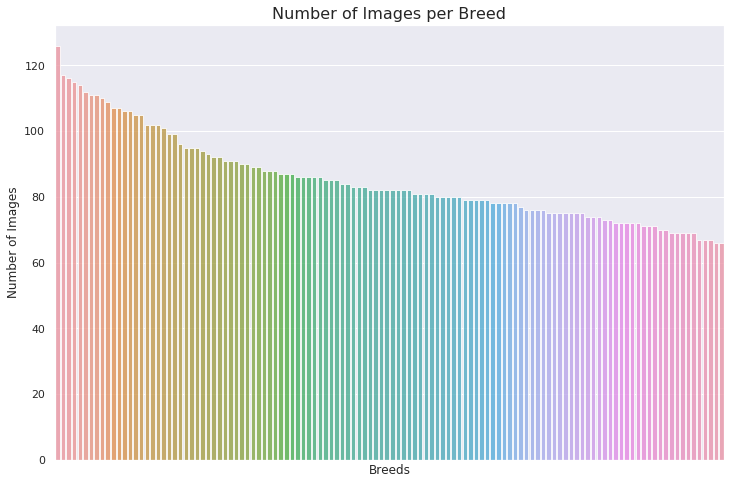

In [5]:
# Plotting a bar chart for the target values
breed_count = labels_csv['breed'].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(breed_count.index, breed_count.values,
            order=breed_count.index,
            alpha=0.8)
plt.title('Number of Images per Breed', fontdict={'fontsize': 16})
plt.ylabel('Number of Images')
plt.xlabel('Breeds')
plt.xticks([]);

In [6]:
# Average number of images per breed
breed_count.median()

82.0

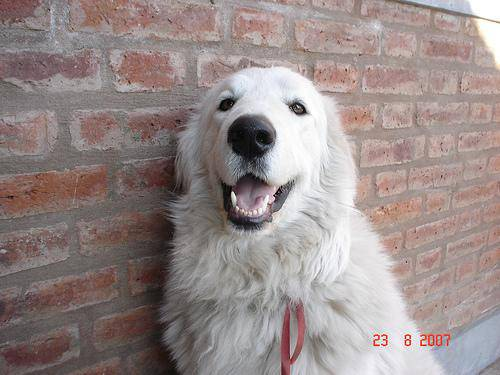

In [7]:
# Let's view an image
from IPython.display import Image
Image('/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/0a0c223352985ec154fd604d7ddceabd.jpg')

### Getting images and their labels

Let's get a list of all image file pathnames.

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
# Create pathnames from image IDs
fpath = '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/'
filenames = [fpath + fname + '.jpg' for fname in labels_csv['id']]
filenames[:5]

['/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [10]:
# Check if number of filenames matches number of actual image files
import os
if len(os.listdir(fpath)) == len(filenames):
  print('Filenames match actual amount of files. Proceed.')
else:
  print(f'Error: actual num of files: {len(os.listdir(fpath))} - labels.csv: {len(filenames)}')

Filenames match actual amount of files. Proceed.


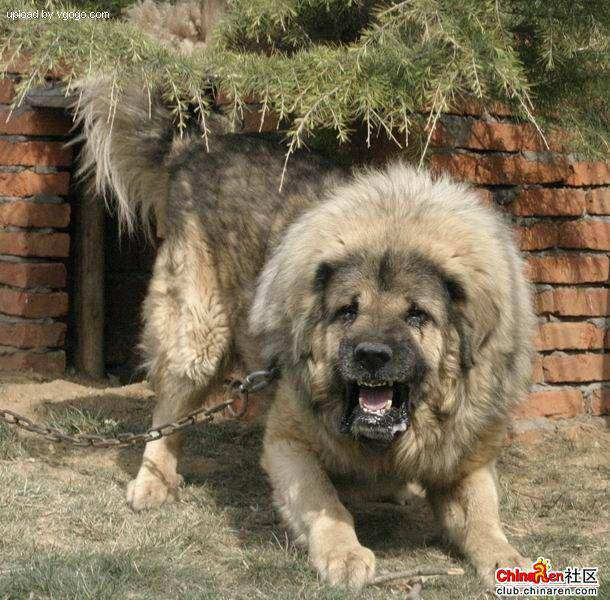

In [11]:
# Another check
Image(filenames[9000])

The training image filepaths are now accessible as a Python list.
Now prepare the labels.

In [12]:
labels = np.array(labels_csv['breed'])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
len(labels)

10222

In [14]:
# Check if number of labels matches number of filenames
len(filenames) == len(labels)

True

In [0]:
unique_breeds = np.unique(labels)

In [52]:
# Check number of unique breeds (should be 120)
len(unique_breeds) == 120

True

**We need to encode the labels**. The labels are categorical data with nominal values (no intrinsic order). See [Categorical Variables](https://github.com/sophiabrandt/udemy-feature-engineering/blob/master/notebooks/original-course-notebooks/Section-02-Types-of-Variables/02.2-Categorical-Variables.ipynb).

In [16]:
# Use LabelBinarizer to encode labels
from sklearn.preprocessing import LabelBinarizer

# Create one-hot encoder
one_hot = LabelBinarizer()

# One-hot encode labels
encoded_labels = one_hot.fit_transform(labels)
encoded_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [0]:
# Setup X & y variables
X = filenames
y = encoded_labels

We're going to start off experimentind with ~1000 images for a fast feedback loop and increase as needed.

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {type: 'slider', min:1000, max: 10222}

In [0]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split data into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=33)

In [34]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [35]:
# Check the training data
X_train[:2], y_train[:2]

(['/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/151f312fa21196af9b53b0e77baa3a06.jpg',
  '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/164a194e9bf8819523235879eb0c2698.jpg'],
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

## Preprocessing Images (Turning Images into Tensors)

We'll write a preprocess function that does the following:

1. Take an image filepath as input (string)
2. Use Tensorflow to read the file and save it to variable `image`
3. Turn `image` (a jpg) into Tensors
4. Normalize image (convert color channel values from 0-255 to 0-1)
5. Resize `image` to be a shape of (224, 224)
6. Return the modified `image`

In [36]:
# Prior step: turn image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[3])
image.shape

(344, 400, 3)

In [37]:
image

array([[[ 71,  67,  66],
        [ 97,  93,  92],
        [ 84,  83,  81],
        ...,
        [ 67,  69,  56],
        [ 56,  62,  50],
        [ 49,  57,  46]],

       [[ 57,  53,  52],
        [ 94,  90,  89],
        [ 92,  91,  89],
        ...,
        [ 46,  48,  35],
        [ 40,  46,  34],
        [ 41,  49,  38]],

       [[ 63,  59,  58],
        [ 99,  95,  94],
        [ 89,  88,  86],
        ...,
        [ 42,  42,  30],
        [ 45,  48,  37],
        [ 58,  64,  52]],

       ...,

       [[104,  88,  75],
        [136, 120, 107],
        [147, 134, 118],
        ...,
        [102,  80,  69],
        [113,  88,  84],
        [117,  89,  88]],

       [[121, 105,  92],
        [ 80,  64,  51],
        [134, 121, 105],
        ...,
        [150, 128, 117],
        [ 93,  68,  64],
        [122,  94,  93]],

       [[114,  98,  85],
        [100,  84,  71],
        [117, 104,  88],
        ...,
        [112,  90,  79],
        [105,  80,  76],
        [121,  93,  92]]

In [38]:
tf.constant(image)

<tf.Tensor: shape=(344, 400, 3), dtype=uint8, numpy=
array([[[ 71,  67,  66],
        [ 97,  93,  92],
        [ 84,  83,  81],
        ...,
        [ 67,  69,  56],
        [ 56,  62,  50],
        [ 49,  57,  46]],

       [[ 57,  53,  52],
        [ 94,  90,  89],
        [ 92,  91,  89],
        ...,
        [ 46,  48,  35],
        [ 40,  46,  34],
        [ 41,  49,  38]],

       [[ 63,  59,  58],
        [ 99,  95,  94],
        [ 89,  88,  86],
        ...,
        [ 42,  42,  30],
        [ 45,  48,  37],
        [ 58,  64,  52]],

       ...,

       [[104,  88,  75],
        [136, 120, 107],
        [147, 134, 118],
        ...,
        [102,  80,  69],
        [113,  88,  84],
        [117,  89,  88]],

       [[121, 105,  92],
        [ 80,  64,  51],
        [134, 121, 105],
        ...,
        [150, 128, 117],
        [ 93,  68,  64],
        [122,  94,  93]],

       [[114,  98,  85],
        [100,  84,  71],
        [117, 104,  88],
        ...,
        [112,  90,  7

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path (string) and turns it into a Tensor.
  """
  # Read the image file
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numerical Tensor with 3 color channels
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert  color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  # Resize image to (224, 244)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning data into batches

Why turn our data into batches?

Large amounts of data might not fit into memory.

We need to limit our images to batch-size. We start with 32 images per run.

To use Tensorflow effectively, the data must be in the form of Tensor tuples.


In [0]:
# Create a function that returns a tuple (image, label)
def to_tf_tuple(image_path, label):
  """
  Takes an image filepath (string) and associated label (numpy array),
  preproccesses the image,
  and returns a tuple of (image, label):
  """
  image = process_image(image_path)
  return image, label

In [40]:
to_tf_tuple(X_train[0], y_train[0])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.08596846, 0.20336589, 0.09521668],
         [0.09337845, 0.20306952, 0.07443587],
         [0.13824561, 0.24353477, 0.07336466],
         ...,
         [0.08181531, 0.09046388, 0.00652503],
         [0.09135146, 0.08634454, 0.00427965],
         [0.10013993, 0.08336842, 0.        ]],
 
        [[0.07033923, 0.17828742, 0.05190045],
         [0.08866125, 0.19302629, 0.04855849],
         [0.1428026 , 0.24278714, 0.06452472],
         ...,
         [0.06947943, 0.07812799, 0.00118656],
         [0.07662807, 0.07082167, 0.        ],
         [0.08103207, 0.07014084, 0.        ]],
 
        [[0.10131304, 0.20132539, 0.04067393],
         [0.12414217, 0.22142656, 0.05334181],
         [0.1863022 , 0.27051088, 0.08806945],
         ...,
         [0.06942457, 0.07600919, 0.00587514],
         [0.07137185, 0.07361695, 0.00481443],
         [0.0757528 , 0.07361695, 0.00481443]],
 
        ...,
 
        [[0.2552524 , 0.14937003

Now let's make a function to turn all our data into batches of Tensor tuples.

In [0]:
# Define batch size
BATCH_SIZE = 32

# Helper function to create a Tensor dataset
def to_tf_dataset(X, y=None):
  """
  Returns a Tensor Dataset from Tensor slices.
  """
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  return dataset

# Create a function to turn data into btches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of size `batch_size` out of image (X) and
  one-hot encoded label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle validation data.
  Also accepts test data as input (no labels).
  """
  # For test data, batch data without labels
  if test_data:
    print('Creating test data batches ...')
    data = to_tf_dataset(tf.constant(X)) # only file paths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # For validation dataset, batch data, with labels, without shuffling
  elif valid_data:
    print('Creating validation data batches ...')
    data = to_tf_dataset(tf.constant(X),  # file paths
                          tf.constant(y)) # labels 
    data_batch = data.map(to_tf_tuple).batch(BATCH_SIZE)
    return data_batch

  # For training data, shuffle and batch, with labels
  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = to_tf_dataset(tf.constant(X),
                          tf.constant(y))
    # Shuffling pathnames and labels
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples
    data = data.map(to_tf_tuple)
    # Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch                                                   

In [47]:
# Creating and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches ...


In [48]:
# Check out the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

## Visualizing Data Batches

The data is now in batches. But they are hard to understand. Let's visualize them!

In [0]:
# Create a funtion for viewing images in a data batch

def show_25_images(images, labels):
  """
  Displays a plot of 25 images
  and their labels from a data batch.
  """
  plt.figure(figsize=(10,10))
  # Loop until 25
  for i in range(25):
    # Create subplots
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis('off')

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [64]:
train_data, train_labels

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int64)>,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]))

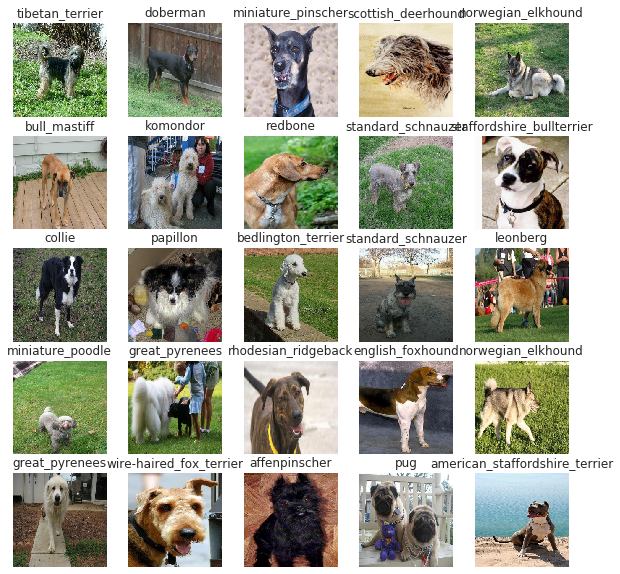

In [65]:
# Let's visualize the data in a training batch
show_25_images(train_images, train_labels)

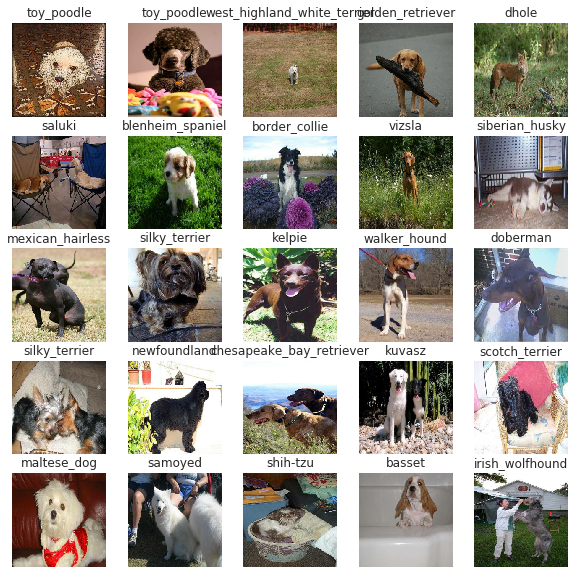

In [67]:
# Visualize data in validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)